# Predicting California House Prices: A Step-by-Step Guide

## The Challenge
 
Imagine you're a real estate analyst tasked with creating a model that can predict house prices across California. You have data about different areas including:
- Location (longitude and latitude)
- Population and household statistics
- Income levels
- Housing characteristics
 
Our goal: Build models that can accurately predict median house values based on these features.
 
> 💡 Fun Fact: Similar models are used by companies like Zillow to estimate house prices. A similar dataset on Kaggle had a prize pool of $1,200,000!

# Import Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Data Preprocessing

Before we jump into our regression models, we need to make sure the data is processed and ready for analysis.

## Loading The Dataset

In [51]:
housing = pd.read_csv("housing.csv")

### Understanding Our Dataset
 
Before we dive into modeling, let's understand exactly what information we have in our dataset. Each row represents a block group (a geographic unit used by the US Census Bureau) in California.
 
#### Feature Breakdown
 
**Geographic Features:**
- `longitude`: West–east position (negative values, as we're in the Western Hemisphere)
   - Range: Approximately -124 to -114
   - Represents California's position on Earth
   - More negative = further west
 
 - `latitude`: North–south position
   - Range: Approximately 32 to 42
   - Higher values = further north
   - Helps identify different regions of California
 
 - `ocean_proximity`: Categorical location relative to the Pacific Ocean
   - Categories: 'NEAR BAY', 'NEAR OCEAN', '<1H OCEAN', 'INLAND', 'ISLAND'
   - Provides context about coastal influence on housing prices
 
 **Housing Characteristics:**
 - `housing_median_age`: Typical age of homes in the area
   - Unit: Years
   - Helps identify newer developments vs. established neighborhoods
   - Can indicate potential maintenance costs or historical value
 
 - `total_rooms`: Total number of rooms in all homes in the area
   - Aggregate count for the block group
   - Indicates overall housing capacity
   - Usually correlates with area development level
 
 - `total_bedrooms`: Total number of bedrooms in all homes in the area
   - Subset of total_rooms
   - Can indicate housing capacity for residents
   - Sometimes has missing values
 
 **Population and Household Data:**
 - `population`: Total number of people living in the area
   - Raw count of residents
   - Indicates demand for housing
   - Can suggest urban vs. rural areas
 
 - `households`: Total number of households (groups of people living together)
   - Usually less than population
   - Indicates actual housing unit usage
   - Important for understanding housing demand
 
 **Economic Indicators:**
 - `median_income`: Typical income for households in the block group
   - Unit: Tens of thousands of dollars (scaled)
   - Example: 8.3 means $83,000
   - Strong predictor of house prices
 
 **Target Variable:**
 - `median_house_value`: Median price of homes in the area
   - Unit: Dollars
   - This is what we're trying to predict
   - Capped at $500,001 in original data
 
 Let's look at some basic statistics for our numerical features:

#### Visualizing Feature Distributions
 
Let's look at how our features are distributed:

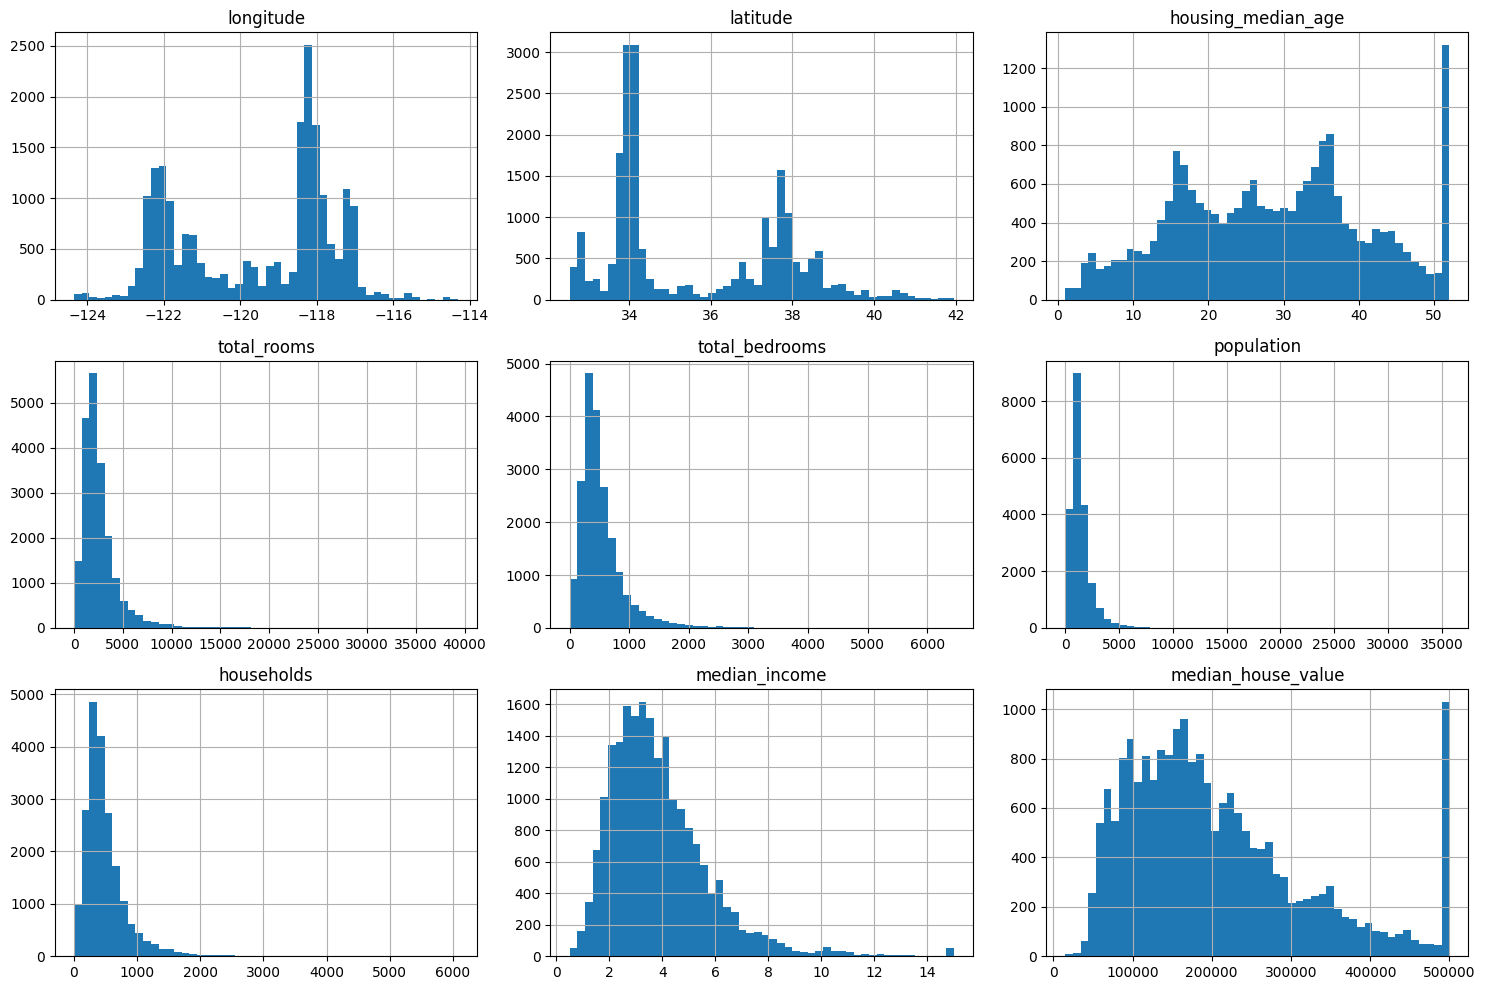

In [52]:
housing.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.show()

In [53]:
print("Dataset Statistics:")
print(housing.describe())

Dataset Statistics:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   


#### Key Observations About Our Data:
 
1. **Geographic Distribution**
    - Data covers all of California
    - Coastal areas are well-represented
    - Some clustering around major cities
 
 2. **Value Ranges**
    - House values are capped at $500,001
    - Income shows significant variation
    - Housing age has multiple peaks (suggesting different development periods)
 
 3. **Potential Challenges**
    - Missing values in total_bedrooms
    - Skewed distributions in several features
    - Geographic features might need special handling
 
 4. **Relationships to Consider**
    - Rooms vs. Bedrooms ratio
    - Population vs. Households
    - Location vs. House Value
 
Let's look at correlations between numerical features:

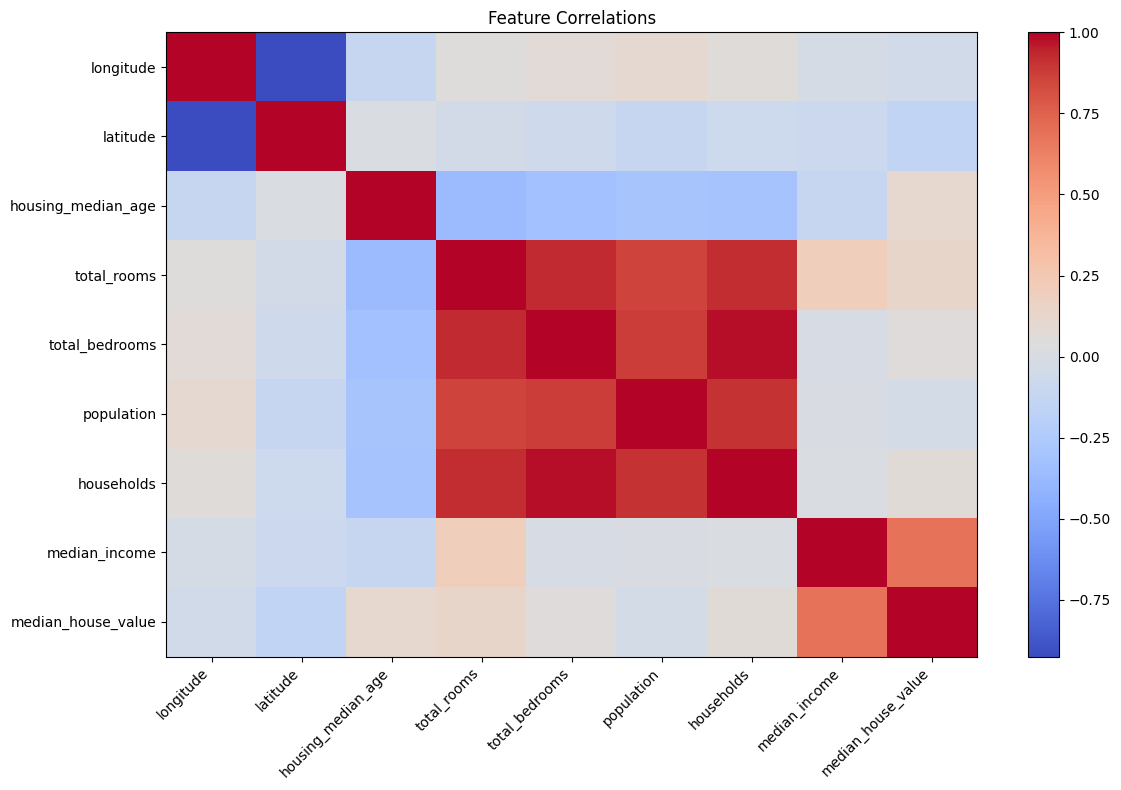

In [54]:
correlation_matrix = housing.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

## Data Cleaning and Preparation
 
### Handling Missing Values
 
 Missing values can cause problems for our models. Let's check if we have any:

In [55]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

We see some missing values in 'total_bedrooms'. We'll handle this using median imputation:

In [56]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean())
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Converting Categorical Data
 
Machine learning models work with numbers, not categories. We need to convert our categorical 'ocean_proximity' data into numerical format.
 
First, let's see what categories we have:

In [57]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [58]:
# We'll use one-hot encoding to convert these categories into numerical columns:
categorical_columns=['ocean_proximity']
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


### Visualize the data
One of the best ways to understand our data is to visualize it. Let's create some informative plots:


Text(0.5, 1.0, 'median_income')

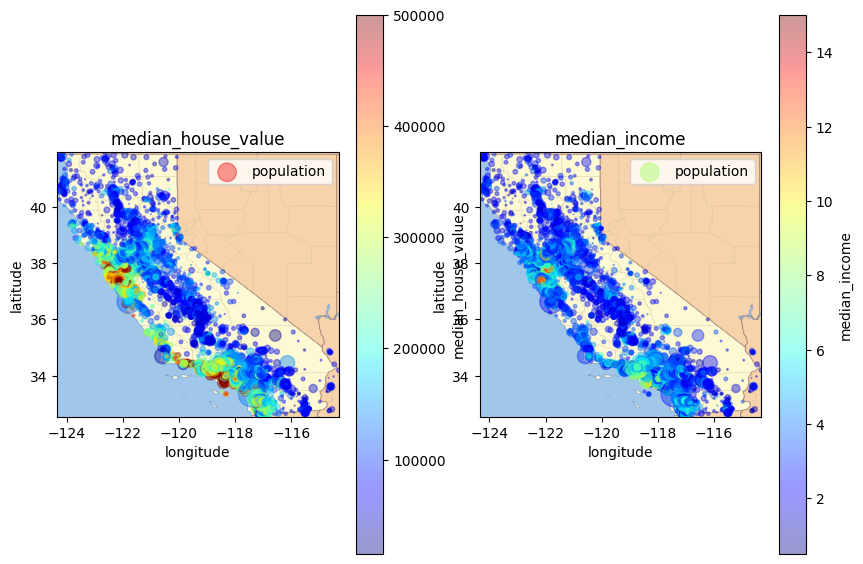

In [59]:
california_img = imread('california.png') # Load the image

# Get the dimensions grid of the image
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)

# the parameter c refers to color
# median_house_value is color-coded in both plots
fig, ax =plt.subplots(1,2)

# Plot house values
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')

# Plot income values
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

These visualizations reveal several interesting patterns:
1. House values tend to be higher near coastal areas
2. There's a strong correlation between income and house values
3. Population density varies significantly across the state
4. The San Francisco Bay Area shows notably high values for both income and house prices

## Preparing for Model Building
 
### Splitting Features and Target
 
We need to separate what we want to predict (target) from what we'll use to make predictions (features):

In [60]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,False,True,False


In [61]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [62]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values
Y=Y.values

### Splitting Data for Training and Testing
 
We'll split our data into three parts:
1. Training set: Used to train our model
2. Validation set: Used to tune our model
3. Test set: Used to evaluate our final model

In [63]:
#trainnig, validation, testing split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


### Feature Scaling
 
Different features have different scales (e.g., income vs. number of rooms). We'll normalize them to be on similar scales:

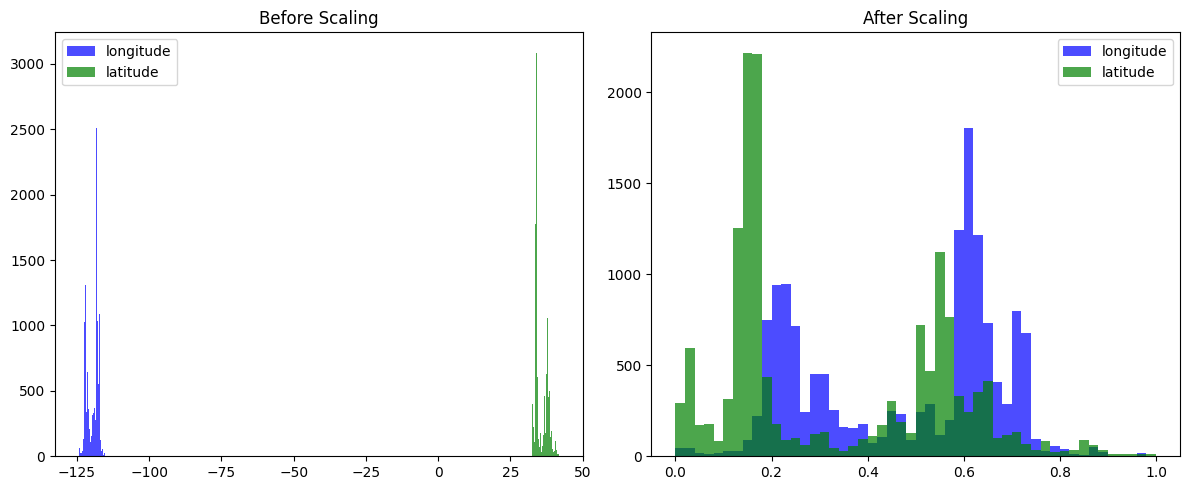

In [64]:
#apply feature normalization to training, validation and test sets
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

# Visualize the effects of scaling on the data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before scaling
ax[0].hist(X[:, 0], bins=50, color='blue', alpha=0.7, label='longitude')
ax[0].hist(X[:, 1], bins=50, color='green', alpha=0.7, label='latitude')
ax[0].set_title('Before Scaling')
ax[0].legend()

# After scaling
ax[1].hist(X_train[:, 0], bins=50, color='blue', alpha=0.7, label='longitude')
ax[1].hist(X_train[:, 1], bins=50, color='green', alpha=0.7, label='latitude')
ax[1].set_title('After Scaling')
ax[1].legend()

plt.tight_layout()
plt.show()

# Building Our First Model: Linear Regression
 
Let's start with the simplest model - linear regression:

In [65]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

## Training Model

Now we are fitting the model to the training data.

In [66]:
linear_model.fit(X_train, Y_train)

LinearRegression()

## Making Predictions

Use the trained model to make meaningful (hopefully) predictions

In [67]:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

# Checking the type of the output
type(Y_train_pred), type(Y_test_pred)


(numpy.ndarray, numpy.ndarray)

## Evaluating Model Performance
 
Let's check how well our model performs using several metrics:
- MSE (Mean Squared Error): Average squared difference between predictions and actual values
- MAE (Mean Absolute Error): Average absolute difference between predictions and actual values
- MAPE (Mean Absolute Percentage Error): Average percentage difference between predictions and actual values

In [68]:
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on traning set
MSE= 4676141000.177793
MAE= 49670.28855989233
MAPE= 0.2871450401622923
Evaluate model on testing set
MSE= 4717315278.6526165
MAE= 49657.8246124031
MAPE= 0.28969601342024487


In [69]:
R2_train = linear_model.score(X_train, Y_train)
R2_test = linear_model.score(X_test, Y_test)
print('R2_train=', R2_train)
print('R2_test=', R2_test)


R2_train= 0.650593695819538
R2_test= 0.6382301818660714


## Visualizing Model Performance
 
Let's create scatter plots to visualize how our predictions compare to actual values:

Text(0, 0.5, 'Y_train_pred')

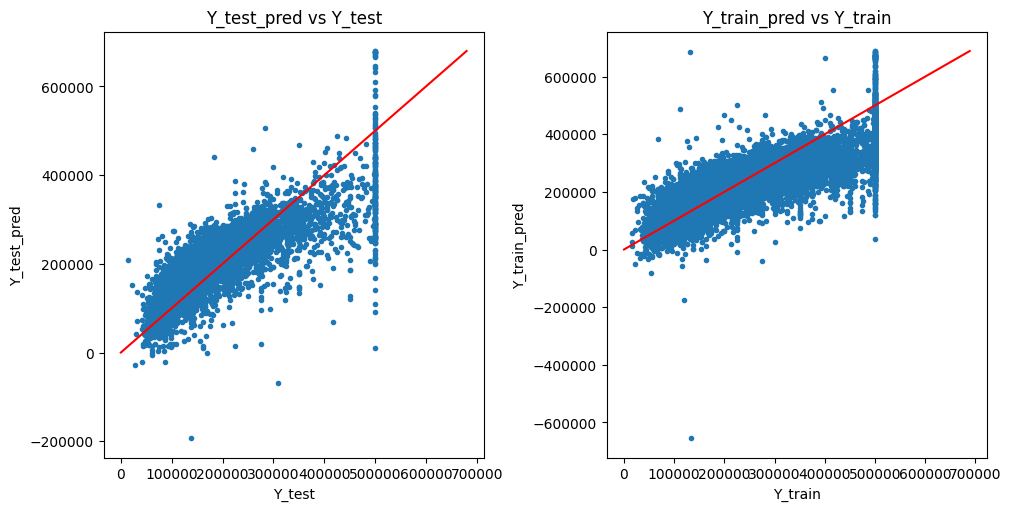

In [70]:
# the red line is the 45-degree line
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
ax[0].set_title('Y_test_pred vs Y_test')
ax[0].plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax[0].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[0].set_xlabel('Y_test')
ax[0].set_ylabel('Y_test_pred')
ax[1].set_title('Y_train_pred vs Y_train')
ax[1].plot(Y_train, Y_train_pred, '.')
ymax=np.max([Y_train.max(), Y_train_pred.max()])
ax[1].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[1].set_xlabel('Y_train')
ax[1].set_ylabel('Y_train_pred')

The red line in each plot represents perfect predictions. Points closer to this line are better predictions.

Text(0.5, 1.0, 'prediction')

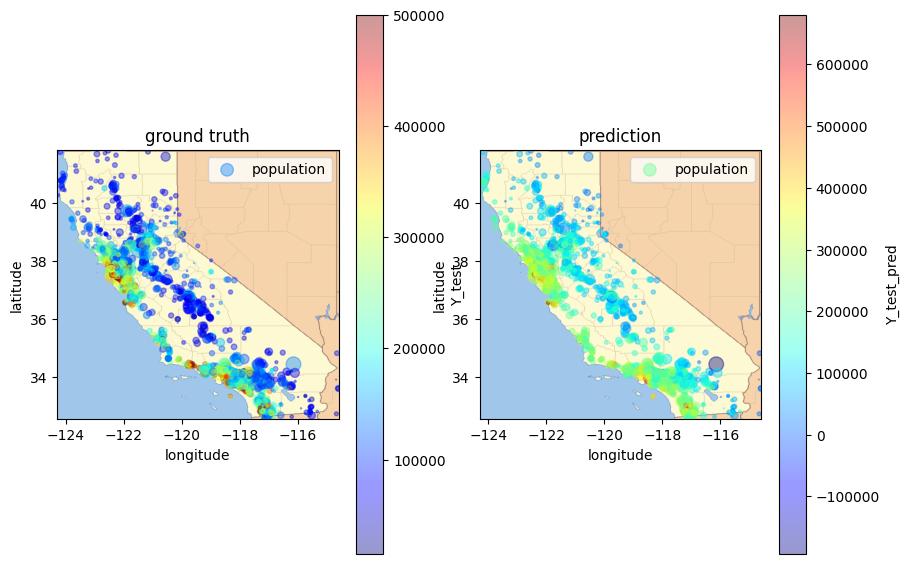

In [71]:
data=scaler.inverse_transform(X_test)
data=pd.DataFrame(data, columns=X_columns)
data['Y_test']=Y_test
data['Y_test_pred']=Y_test_pred

x1 = min(data["longitude"].values)
x2 = max(data["longitude"].values)
y1 = min(data["latitude"].values)
y2 = max(data["latitude"].values)

fig, ax =plt.subplots(1,2)

# Actual values
data.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
          s=data['population']/100, label="population",
          c="Y_test", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, figsize=(10,7))
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('ground truth')

# Predicted values
data.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
          s=data['population']/100, label="population",
          c="Y_test_pred", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('prediction')

## Key Insights:
 
1. **Model Performance**: Our linear regression model captures general trends but has room for improvement.
 
2. **Geographic Patterns**: The model recognizes that coastal areas and major cities tend to have higher house values.
 
3. **Prediction Quality**: The model performs similarly on training and test data, suggesting it's not overfitting.
 
4. **Areas for Improvement**: The model sometimes struggles with extreme values (very high or very low house prices).
 
In the next sections, we'll explore more sophisticated models to improve our predictions!

In [72]:
Y_test.shape

(4128,)

# Advanced Regression Models for House Price Prediction

Now that we've built our baseline linear regression model, let's explore more sophisticated approaches that might capture complex patterns in our housing data better

## K-Nearest Neighbors (KNN) Regression

KNN works differently from linear regression:
- Instead of learning coefficients, it remembers all training examples
- Makes predictions by looking at the most similar houses in our data
- "Similar" means close in terms of our features (location, size, etc.)

Advantages:
- Can capture complex, non-linear patterns
- No assumptions about data relationships
- Simple to understand

Disadvantages:
- Can be slow with large datasets
- Needs feature scaling
- Requires careful choice of k (number of neighbors)

Let's implement it:

### Finding the Best K

The number of neighbors (k) is crucial for KNN performance. Let's try different values:

In [73]:
n_neighbors_list = np.arange(1, 21)
acc_train_list = []
acc_val_list = []

for n_neighbors in n_neighbors_list:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)
    
    # Calculate training and validation errors
    Y_train_pred = knn.predict(X_train)
    Y_val_pred = knn.predict(X_val)
    
    train_mape = np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
    val_mape = np.mean(np.abs(Y_val - Y_val_pred)/Y_val)
    
    acc_train_list.append(train_mape)
    acc_val_list.append(val_mape)
    
    # Save the best knn model
    if val_mape == min(acc_val_list):
        best_knn = knn

### Visualizing the Effect of K

Let's plot how the error changes with different k values:

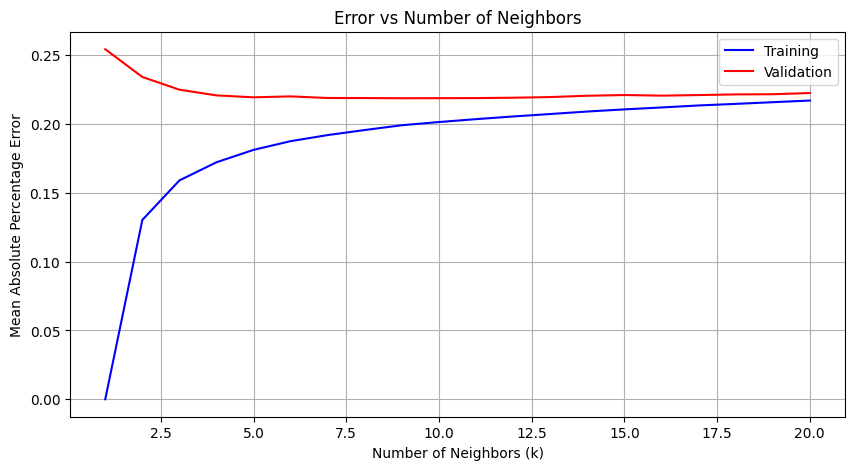

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_list, acc_train_list, 'b-', label='Training')
plt.plot(n_neighbors_list, acc_val_list, 'r-', label='Validation')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Error vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

Now we will use the optimized knn model to make our predictions.

In [75]:
Y_train_pred = best_knn.predict(X_train)
Y_test_pred = best_knn.predict(X_test)

### Evaluating KNN Performance

Let's see how our KNN model performs:

In [76]:
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

print('\nEvaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)



Evaluate model on traning set
MSE= 2995362805.8236704
MAE= 36853.509982054726
MAPE= 0.19911597217585084

Evaluate model on testing set
MSE= 3924165015.067276
MAE= 42531.20356912144
MAPE= 0.23222271665556246


In [77]:
R2_train = knn.score(X_train, Y_train)
R2_test = knn.score(X_test, Y_test)
print('R2 on training set ', R2_train)
print('R2 on testing set ', R2_test)


R2 on training set  0.7392822845614768
R2 on testing set  0.6894097455009857


Text(0, 0.5, 'Y_train_pred')

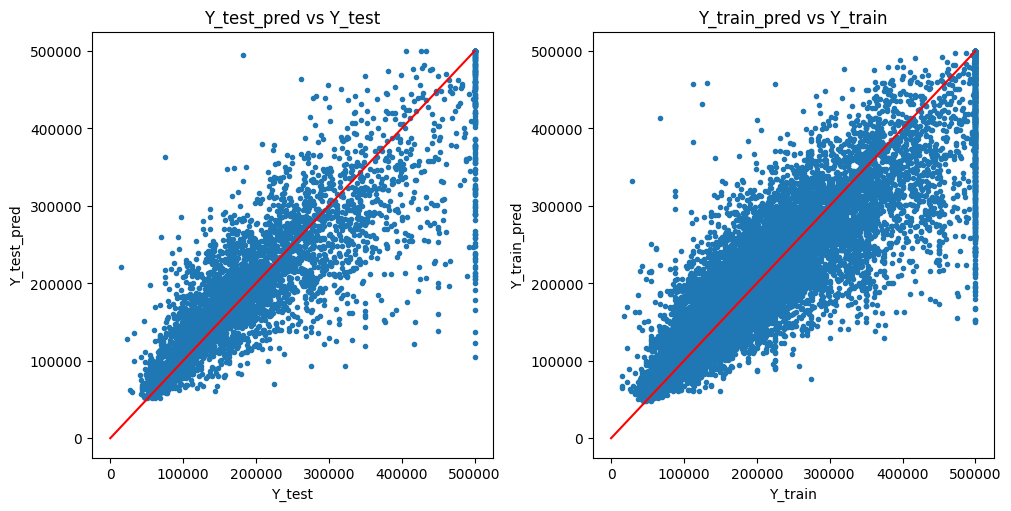

In [78]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
ax[0].set_title('Y_test_pred vs Y_test')
ax[0].plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax[0].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[0].set_xlabel('Y_test')
ax[0].set_ylabel('Y_test_pred')
ax[1].set_title('Y_train_pred vs Y_train')
ax[1].plot(Y_train, Y_train_pred, '.')
ymax=np.max([Y_train.max(), Y_train_pred.max()])
ax[1].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[1].set_xlabel('Y_train')
ax[1].set_ylabel('Y_train_pred')


Now, lets visualize and compare what our predictions look like on the testing set compared to the truth.

Text(0.5, 1.0, 'prediction')

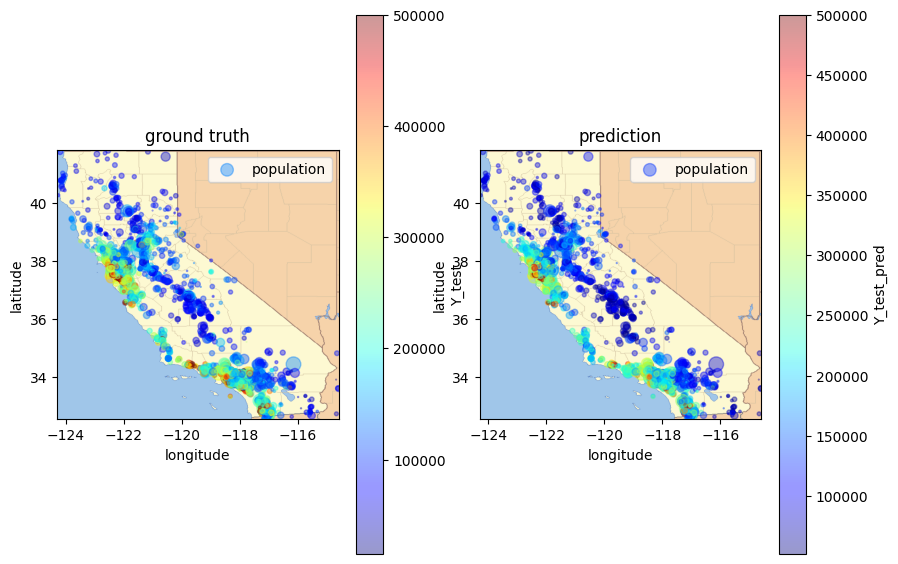

In [79]:
# Reverse the scaling
data=scaler.inverse_transform(X_test)
data=pd.DataFrame(data, columns=X_columns)

# Add the predicted values
data['Y_test'] = Y_test
data['Y_test_pred'] = Y_test_pred

# Get the dimensions grid of the image
x1 = min(data["longitude"].values)
x2 = max(data["longitude"].values)
y1 = min(data["latitude"].values)
y2 = max(data["latitude"].values)

fig, ax =plt.subplots(1,2)

# Actual values
data.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
          s=data['population']/100, label="population",
          c="Y_test", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, figsize=(10,7))
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('ground truth')

# Predicted values
data.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
            s=data['population']/100, label="population",
            c="Y_test_pred", cmap=plt.get_cmap("jet"),
            colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('prediction')


## Random Forest Regression

Random Forest combines many decision trees to make predictions. Think of it as:
- Building many different decision trees
- Each tree sees a random subset of features and data
- Final prediction is the average of all trees

Advantages:
- Usually more accurate than single models
- Less prone to overfitting
- Can handle non-linear relationships
- Provides feature importance scores

Let's implement it:

In [80]:
RF = RandomForestRegressor(n_estimators=20, max_depth=10)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, n_estimators=20)

In [81]:
Y_train_pred = RF.predict(X_train)
Y_test_pred = RF.predict(X_test)


### Evaluate Baseline Random Forest Preformance

Lets look at how our model did before we optimize.

In [82]:
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)



Evaluate model on traning set
MSE= 1916648046.559373
MAE= 30326.39428610851
MAPE= 0.17303993647888
Evaluate model on testing set
MSE= 2904330213.9938436
MAE= 36551.38513513424
MAPE= 0.20780593555203922


In [83]:
R2_train = RF.score(X_train, Y_train)
R2_test = RF.score(X_test, Y_test)
print('R2_train=', R2_train)
print('R2_test=', R2_test)

R2_train= 0.8567859886308924
R2_test= 0.7772675873346475


Text(0, 0.5, 'Y_train_pred')

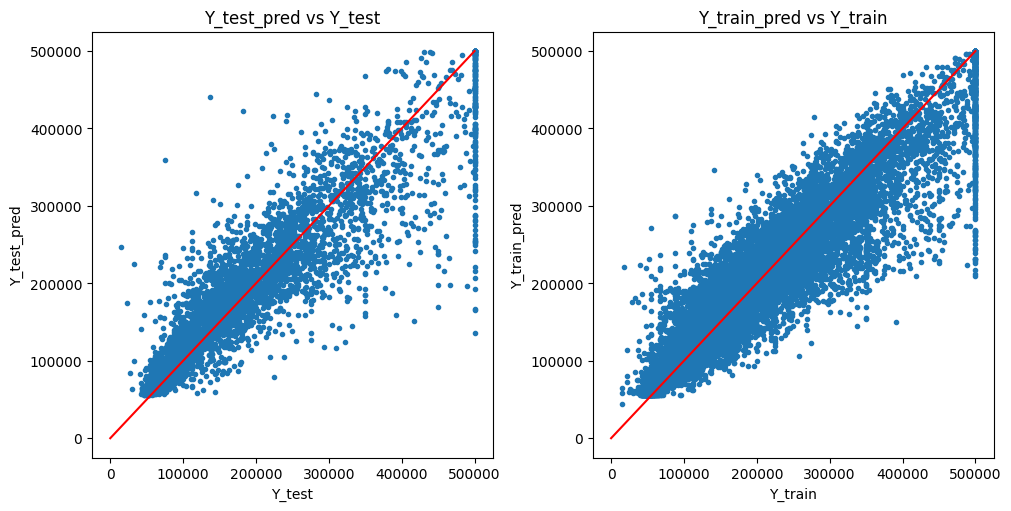

In [84]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
ax[0].set_title('Y_test_pred vs Y_test')
ax[0].plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax[0].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[0].set_xlabel('Y_test')
ax[0].set_ylabel('Y_test_pred')

ax[1].set_title('Y_train_pred vs Y_train')
ax[1].plot(Y_train, Y_train_pred, '.')
ymax=np.max([Y_train.max(), Y_train_pred.max()])
ax[1].plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax[1].set_xlabel('Y_train')
ax[1].set_ylabel('Y_train_pred')



Text(0.5, 1.0, 'prediction')

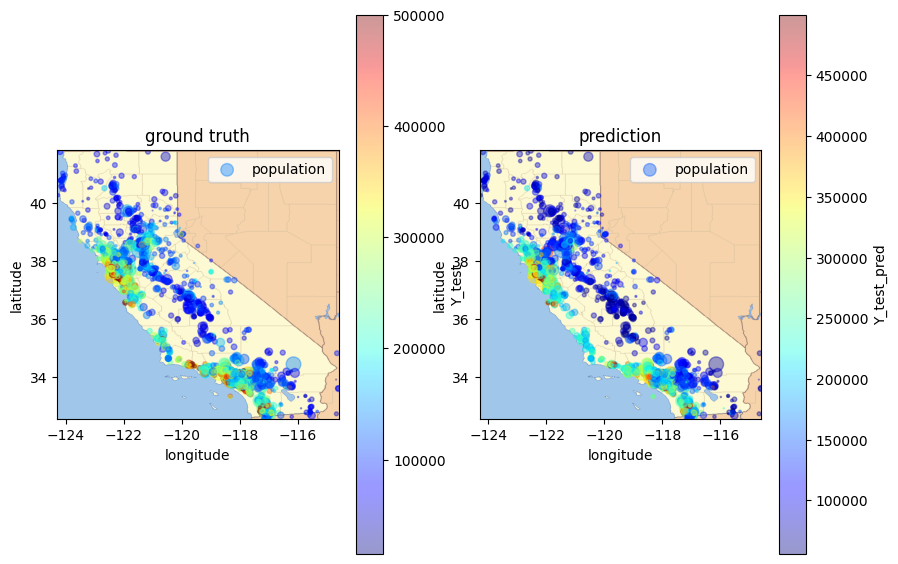

In [85]:
# Reverse the scaling
data=scaler.inverse_transform(X_test)

# convert numpy array to pandas dataframe
data=pd.DataFrame(data, columns=X_columns)

# Add the predicted values
data['Y_test']=Y_test
data['Y_test_pred']=Y_test_pred

# Get the dimensions grid of the image
x1 = min(data["longitude"].values)
x2 = max(data["longitude"].values)
y1 = min(data["latitude"].values)
y2 = max(data["latitude"].values)

fig, ax =plt.subplots(1,2)
# Actual values
data.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
          s=data['population']/100, label="population",
          c="Y_test", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, figsize=(10,7))
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('ground truth')

# Predicted values
data.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
          s=data['population']/100, label="population",
          c="Y_test_pred", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('prediction')


### Optimizing Random Forest

The max_depth parameter controls how detailed each tree can be. Let's find the optimal depth:

In [86]:
# Create a list of values for the parameter n_estimators
max_depth_list = np.arange(1, 100, 10)
max_depth_list

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [87]:
MAE_train_list=[]
MAE_val_list=[]

for max_depth in max_depth_list:
    RF = RandomForestRegressor(n_estimators=20, max_depth=max_depth, random_state=0)
    RF.fit(X_train, Y_train)
    Y_train_pred = RF.predict(X_train)
    Y_val_pred = RF.predict(X_val)
    MAE_train = np.mean(np.abs(Y_train - Y_train_pred))
    MAE_val = np.mean(np.abs(Y_val - Y_val_pred))
    MAE_train_list.append(MAE_train)
    MAE_val_list.append(MAE_val)


### Visualizing the Effect of Tree Depth

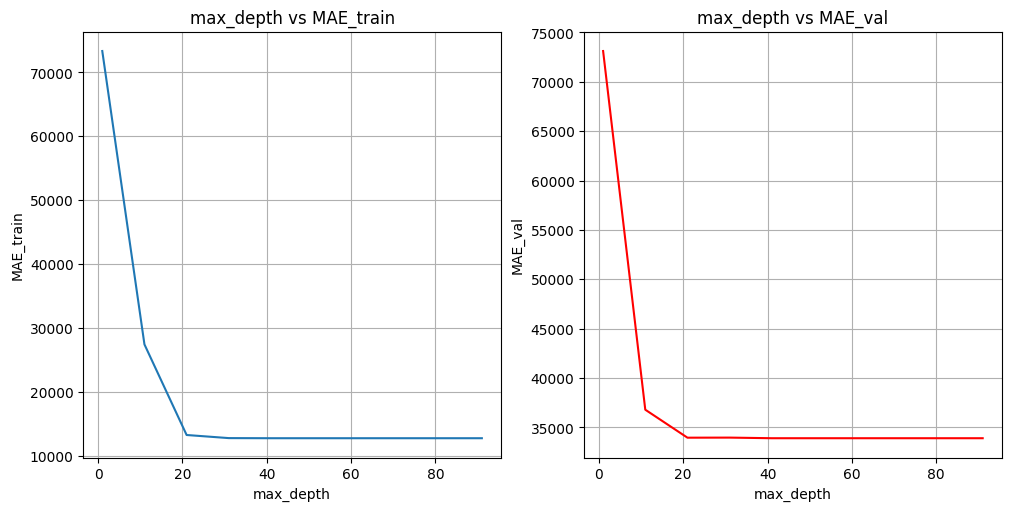

In [88]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
ax[0].plot(max_depth_list, MAE_train_list)
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('MAE_train')
ax[0].set_title('max_depth vs MAE_train')
ax[0].grid()
ax[1].plot(max_depth_list, MAE_val_list, color='r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('MAE_val')
ax[1].set_title('max_depth vs MAE_val')
ax[1].grid()



In [89]:
max_depth_best_rf = max_depth_list[np.argmin(MAE_val_list)]
print('best max_depth:', max_depth_best_rf)

best max_depth: 41


In [90]:
# retrain the model using the best max_depth
RF = RandomForestRegressor(n_estimators=20, max_depth=max_depth_best_rf, random_state=0)
RF.fit(X_train, Y_train)
Y_train_pred = RF.predict(X_train)
Y_test_pred = RF.predict(X_test)

# Evaluate the model
print("Evaluate model on traning set")
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

print("\nEvaluate model on testing set")
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)


Evaluate model on traning set
MSE= 406815254.97324914
MAE= 12744.596086810228
MAPE= 0.07088217234331308

Evaluate model on testing set
MSE= 2468244647.135874
MAE= 32576.701417151166
MAPE= 0.18577866683250946


### Feature Importance

One advantage of Random Forest is that it can tell us which features matter most:

<BarContainer object of 13 artists>

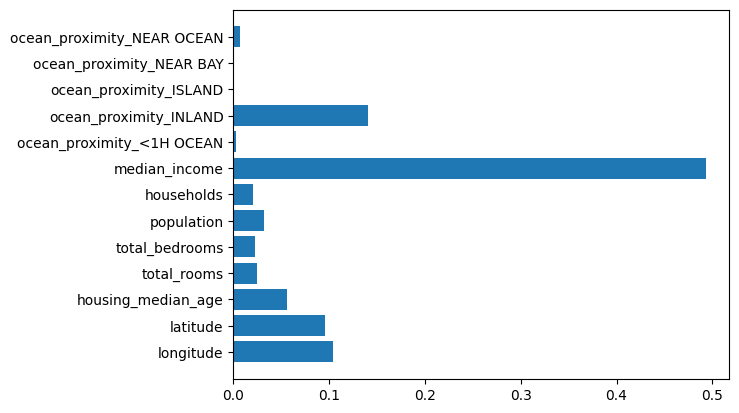

In [91]:
plt.barh(y=X_columns, width=RF.feature_importances_)

## XGBoost Regression

XGBoost (eXtreme Gradient Boosting) is a powerful and popular model that:
- Builds trees sequentially, each correcting the mistakes of previous trees
- Often provides better predictions than simpler models
- Widely used in data science competitions and industry

Advantages:
- Usually gives excellent accuracy
- Can handle non-linear relationships
- Built-in handling of missing values
- Fast training and prediction

Let's implement it:

In [92]:
# Create initial model with default parameters
xgb = XGBRegressor(random_state=0, objective='reg:squarederror')
xgb.fit(X_train, Y_train)

# Predict on training and testing sets
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)

### Evaluating XGBoost Performance

Let's check how our initial XGBoost model performs:

In [93]:
print('Training Set Performance:')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE = np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE:', MSE)
print('MAE:', MAE)
print('MAPE:', MAPE)

print('\nTest Set Performance:')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE:', MSE)
print('MAE:', MAE)
print('MAPE:', MAPE)

Training Set Performance:
MSE: 759953507.7087867
MAE: 19565.46406223713
MAPE: 0.11196357644511899

Test Set Performance:
MSE: 2145129424.266567
MAE: 30875.28882025194
MAPE: 0.17429715318396366


### Optimizing XGBoost

Like Random Forest, XGBoost has several important parameters. Let's focus on max_depth:

In [94]:
#create an array of possible max_depth
max_depth_list = np.arange(1, 31)
max_depth_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [95]:
MAE_train_list=[]
MAE_val_list=[]

for max_depth in max_depth_list:
    XGB = XGBRegressor(n_estimators=20, max_depth=max_depth, random_state=0)
    XGB.fit(X_train, Y_train)
    Y_train_pred = XGB.predict(X_train)
    Y_val_pred = XGB.predict(X_val)
    MAE_train = np.mean(np.abs(Y_train - Y_train_pred))
    MAE_val = np.mean(np.abs(Y_val - Y_val_pred))
    MAE_train_list.append(MAE_train)
    MAE_val_list.append(MAE_val)


### Visualizing Parameter Tuning

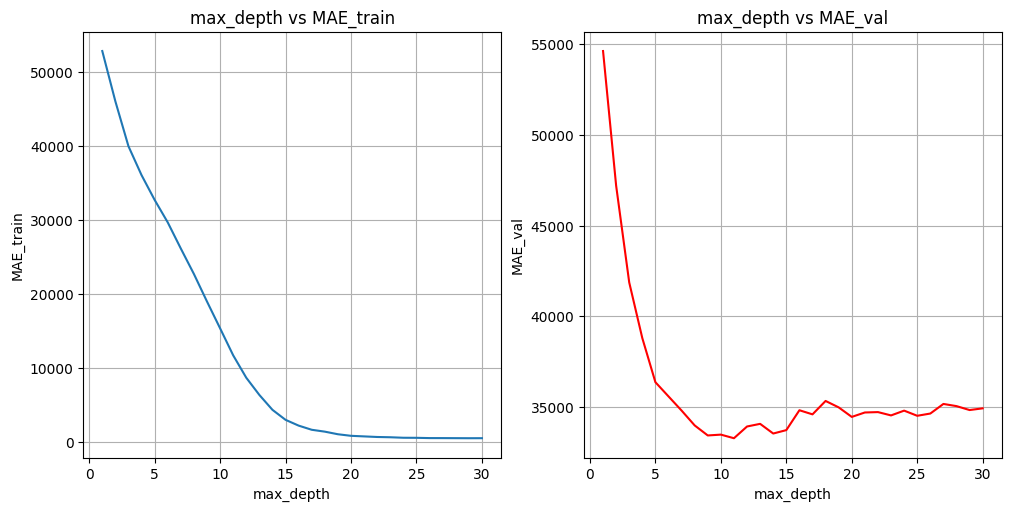

In [96]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
ax[0].plot(max_depth_list, MAE_train_list)
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('MAE_train')
ax[0].grid()
ax[0].set_title('max_depth vs MAE_train')
ax[1].plot(max_depth_list, MAE_val_list, color='r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('MAE_val')
ax[1].set_title('max_depth vs MAE_val')
ax[1].grid()


In [97]:
#find max_depth_best_xg using np.argmin, max_depth_list and MAE_val_list
max_depth_best_xg = max_depth_list[np.argmin(MAE_val_list)]
print('best max_depth:', max_depth_best_xg)

best max_depth: 11


In [98]:
#train and test a XGBRegressor using the best max_depth
XGB = XGBRegressor(n_estimators=20, max_depth=max_depth_best_xg, random_state=0)
XGB.fit(X_train, Y_train)

Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)

print("Evaluate model on traning set")
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

print("\nEvaluate model on testing set")
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)


Evaluate model on traning set
MSE= 304213803.6713753
MAE= 11723.399843723713
MAPE= 0.06996336545625627

Evaluate model on testing set
MSE= 2291837107.90727
MAE= 31851.727587322857
MAPE= 0.17896494918430192


#### Feature Importance in XGBoost

XGBoost also provides feature importance scores, but calculates them differently from Random Forest:

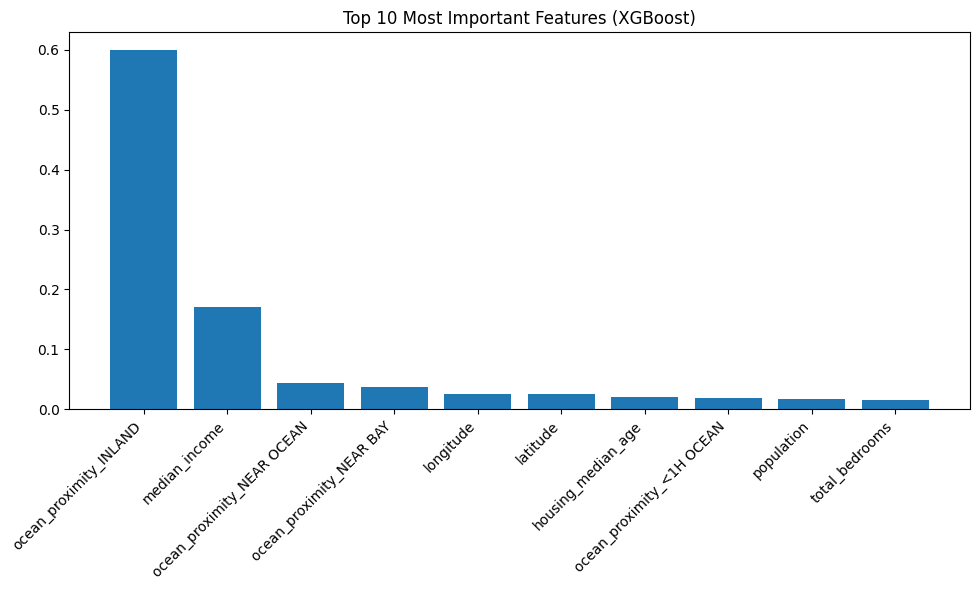

In [99]:
feature_importance = pd.DataFrame({
    'feature': X_columns,
    'importance': xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

### Understanding XGBoost's Predictions

Let's visualize how XGBoost's predictions compare to actual values:

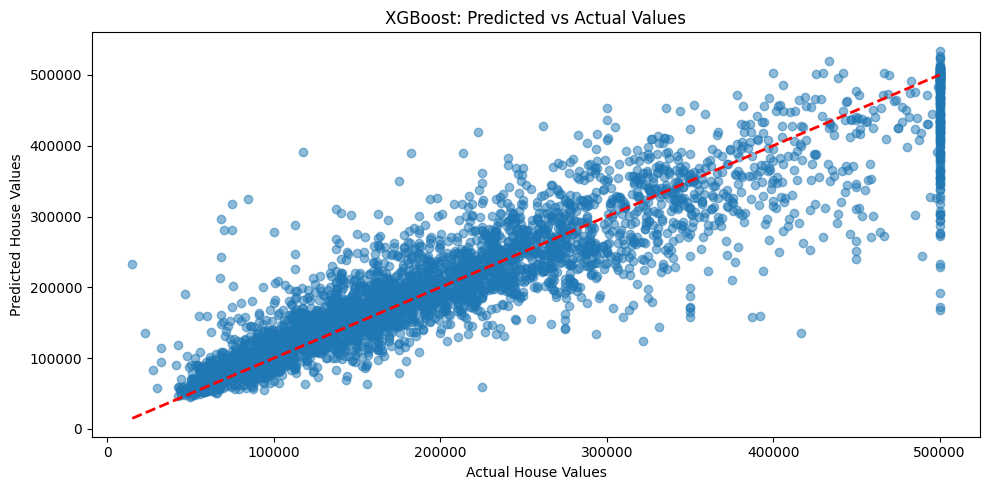

In [100]:
plt.figure(figsize=(10, 5))
plt.scatter(Y_test, Y_test_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Values')
plt.ylabel('Predicted House Values')
plt.title('XGBoost: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# Model Comparison

Let's compare all four models (Linear Regression, KNN, Random Forest, and XGBoost):

I have created a function to assess the models' preformances based on a number of metrics we care about. 

You don't have to understand this code.

In [101]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation function that returns multiple performance metrics
    and creates visualization of predictions.
    Parameters:
    model: sklearn-compatible model
    X_train: training features
    X_test: test features
    y_train: training target
    y_test: test target
    model_name: string name of the model for plotting

    Returns:
    dict: Dictionary containing various performance metrics
    """
    # Fit the model and time it
    from time import time
    start_time = time()
    model.fit(X_train, y_train)
    train_time = time() - start_time

    # Make predictions
    start_time = time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predict_time = time() - start_time

    # Calculate various metrics
    def calculate_metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred)**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        # R² score
        r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
        return mse, rmse, mae, mape, r2

    # Get metrics for both training and test sets
    train_mse, train_rmse, train_mae, train_mape, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mse, test_rmse, test_mae, test_mape, test_r2 = calculate_metrics(y_test, y_test_pred)

    # Visualize predictions vs actual values
    plt.figure(figsize=(15, 5))

    # Training set predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: Training Set Predictions')

    # Test set predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: Test Set Predictions')

    plt.tight_layout()
    plt.show()

    # Return all metrics in a dictionary
    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'test_r2': test_r2,
        'train_time': train_time,
        'predict_time': predict_time
    }
        


Evaluating Linear Regression...


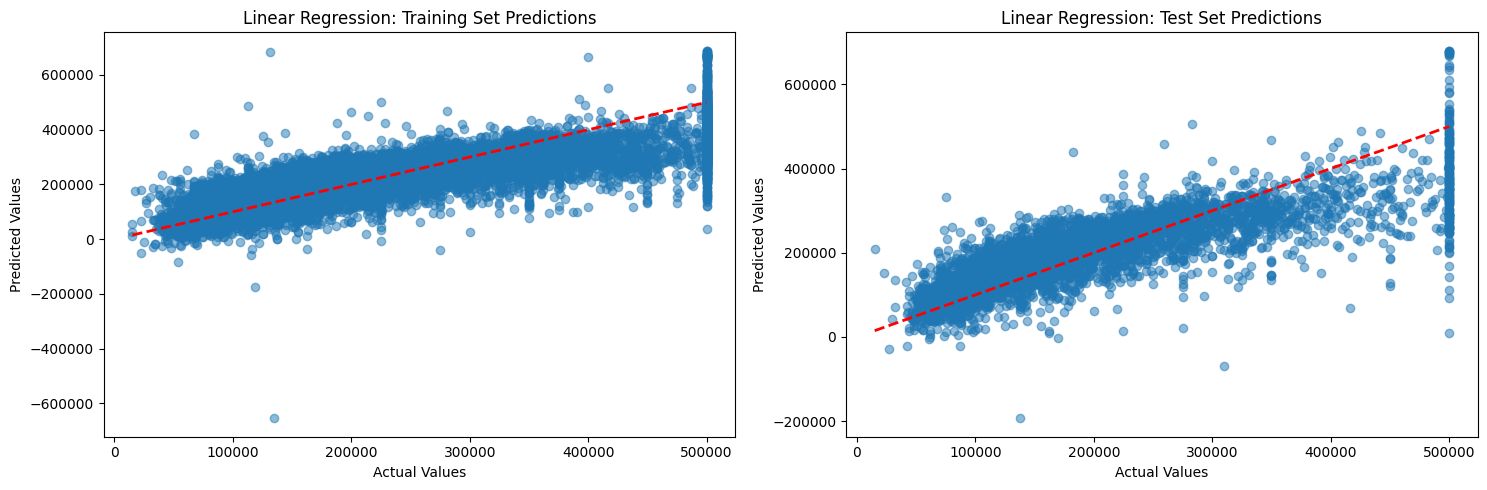


Evaluating KNN...


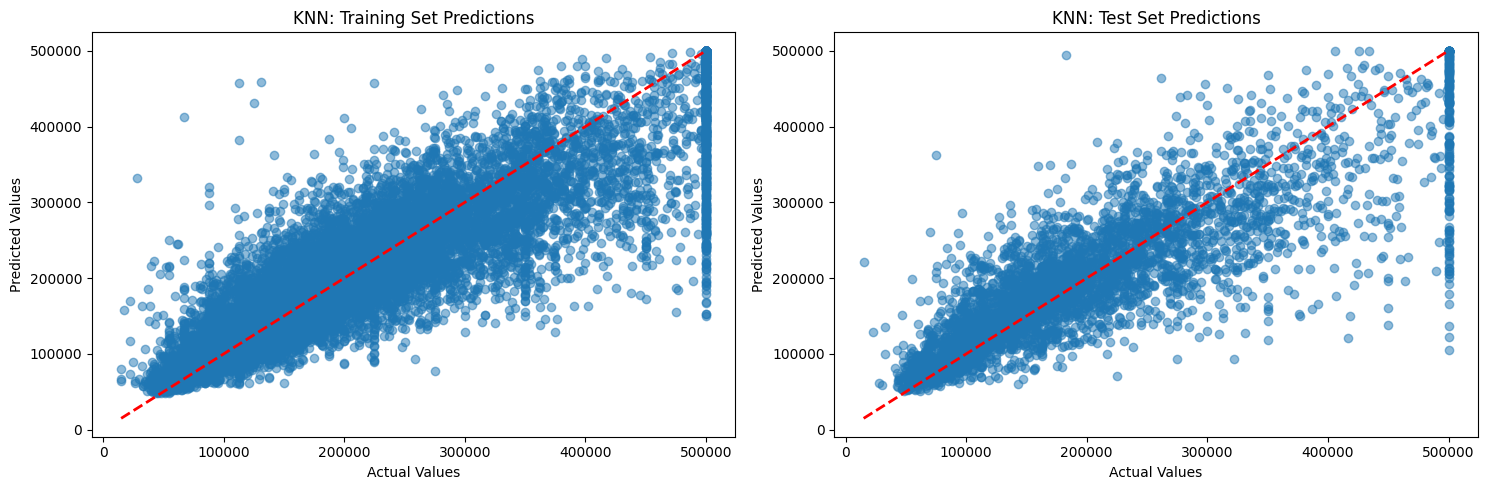


Evaluating Random Forest...


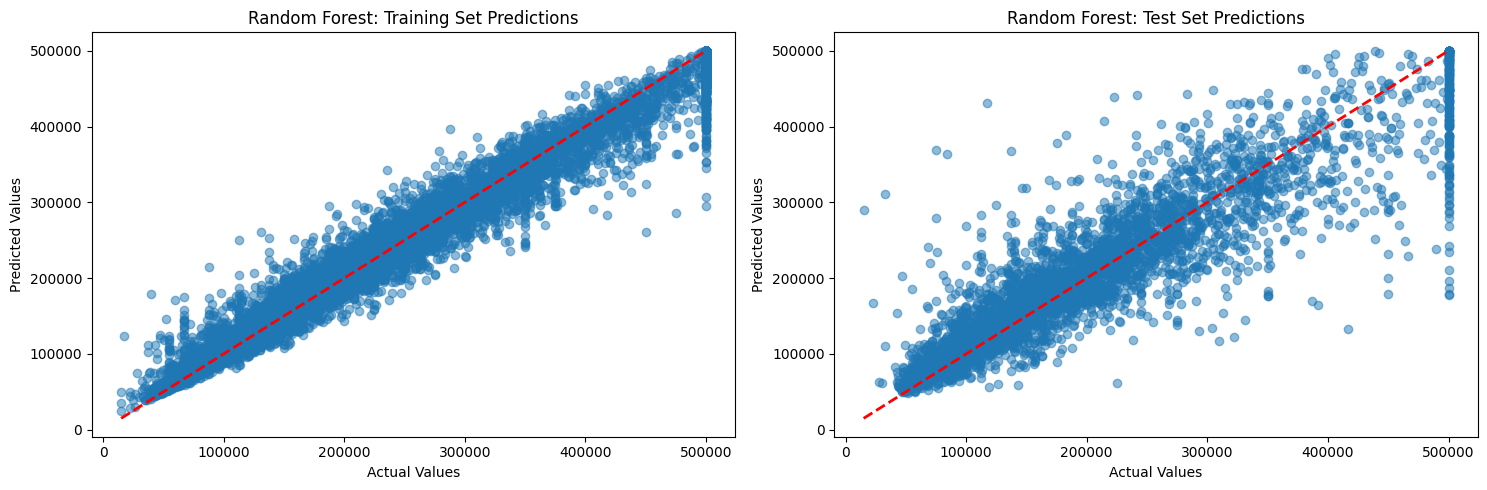


Evaluating XGBoost...


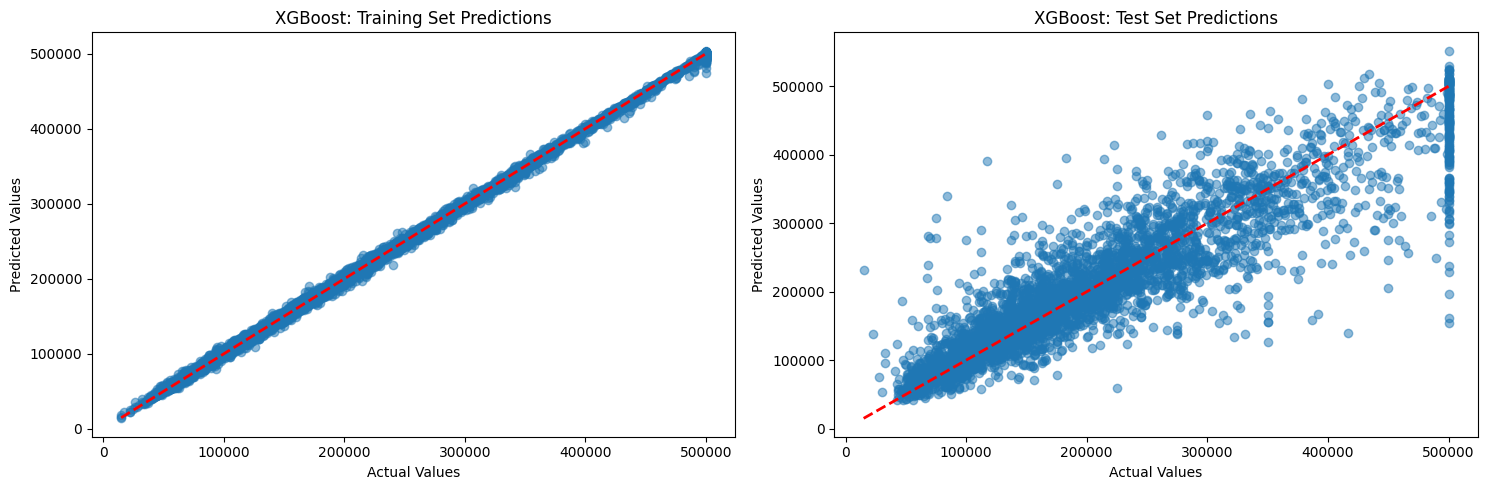

In [102]:
# Define models with best hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=best_knn.n_neighbors),
    'Random Forest': RandomForestRegressor(n_estimators=20, max_depth=max_depth_best_rf, random_state=0),
    'XGBoost': XGBRegressor(max_depth=max_depth_best_xg, random_state=0, objective='reg:squarederror')
}

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, Y_train, Y_test, name)

In [103]:
# Create a DataFrame from the results dictionary
metrics = ['test_rmse', 'test_mae', 'test_mape', 'test_r2', 'train_time', 'predict_time']
comparison_data = {name: {metric: results[name][metric] for metric in metrics}
for name in models.keys()}
comparison_df = pd.DataFrame(comparison_data).T

# Rename columns for better display
comparison_df.columns = ['RMSE', 'MAE', 'MAPE (%)', 'R²', 'Training Time (s)', 'Prediction Time (s)']
print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
                           RMSE           MAE   MAPE (%)        R²  \
Linear Regression  68682.714555  49657.824612  28.969601  0.638230   
KNN                62643.156171  42531.203569  23.222272  0.699057   
Random Forest      49681.431613  32576.701417  18.577867  0.810711   
XGBoost            47700.828372  31677.423481  17.731811  0.825502   

                   Training Time (s)  Prediction Time (s)  
Linear Regression           0.004572             0.028866  
KNN                         0.004585             0.411220  
Random Forest               1.666371             0.071776  
XGBoost                     0.616737             0.009688  


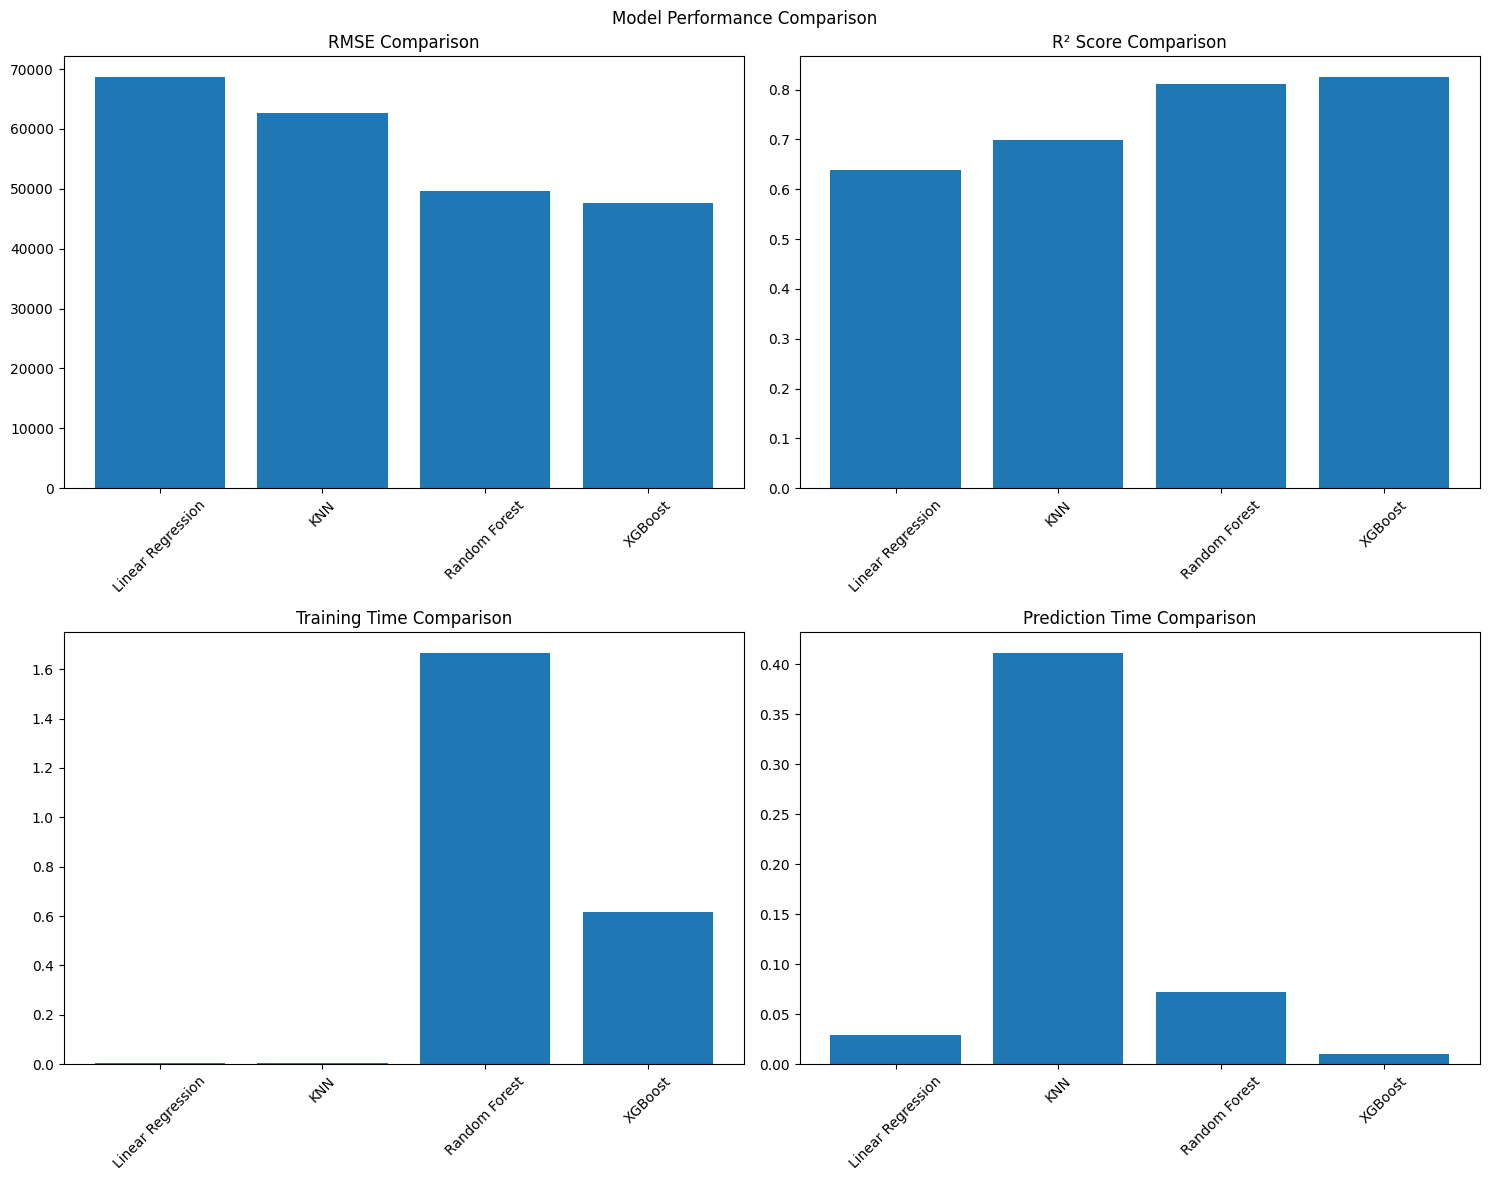

In [104]:
#Create multiple comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison')

# RMSE Comparison
axes[0,0].bar(models.keys(), [results[name]['test_rmse'] for name in models.keys()])
axes[0,0].set_title('RMSE Comparison')
axes[0,0].tick_params(axis='x', rotation=45)

# R^2 Score Comparison
axes[0,1].bar(models.keys(), [results[name]['test_r2'] for name in models.keys()])
axes[0,1].set_title('R² Score Comparison')
axes[0,1].tick_params(axis='x', rotation=45)

# Training Time Comparison
axes[1,0].bar(models.keys(), [results[name]['train_time'] for name in models.keys()])
axes[1,0].set_title('Training Time Comparison')
axes[1,0].tick_params(axis='x', rotation=45)

# Prediction Time Comparison
axes[1,1].bar(models.keys(), [results[name]['predict_time'] for name in models.keys()])
axes[1,1].set_title('Prediction Time Comparison')
axes[1,1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

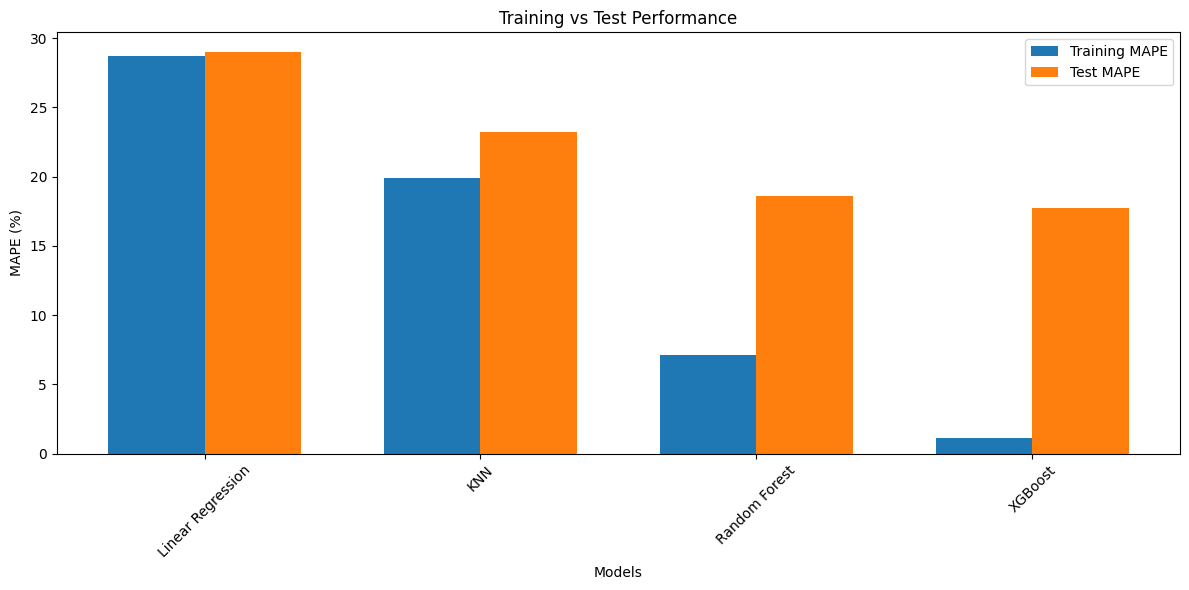

In [105]:
# Create training vs test performance comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, [results[name]['train_mape'] for name in models.keys()],
width, label='Training MAPE')
plt.bar(x + width/2, [results[name]['test_mape'] for name in models.keys()],
width, label='Test MAPE')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.title('Training vs Test Performance')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Key Takeaways

1. Model Trade-offs:
   - Linear Regression: Simple but limited in capturing complex patterns
   - KNN: Better with non-linear patterns but sensitive to k choice
   - Random Forest: Good balance of accuracy and interpretability
   - XGBoost: Highest accuracy but most complex to tune

2. Important Considerations:
   - Training time increases with model complexity
   - More complex models need more data
   - Feature importance varies between models
   - XGBoost often performs best but requires more tuning

3. Next Steps:
   - Try feature engineering to create better inputs
   - Experiment with advanced model hyperparameters
   - Consider ensemble methods combining multiple models
   - Explore other boosting algorithms like LightGBM or CatBoost